**总共包含6个csv文件**

1. train_users_2.csv - the training set of users （训练数据）
2. test_users.csv - the test set of users （测试数据）
    1. id: user id （用户id）
    2. date_account_created（帐号注册时间）: the date of account creation
    3. timestamp_first_active（首次活跃时间）: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
    4. date_first_booking（首次订房时间）: date of first booking
    5. gender（性别）
    6. age（年龄）
    7. signup_method（注册方式）
    8. signup_flow（注册页面）: the page a user came to sign up from
    9. language（语言）: international language preference
    10. affiliate_channel（付费市场渠道）: what kind of paid marketing
    11. affiliate_provider（付费市场渠道名称）: where the marketing is e.g. google, craigslist, other
    12. first_affiliate_tracked（注册前第一个接触的市场渠道）: whats the first marketing the user interacted with before the signing up
    13. signup_app（注册app）
    14. first_device_type(设备类型)
    15. first_browser（浏览器类型）
    16. country_destination（订房国家-需要预测的量）: this is the target variable you are to predict
3. sessions.csv - web sessions log for users（网页浏览数据）
    1. user_id（用户id）: to be joined with the column ‘id’ in users table
    2. action(用户行为)
    3. action_type（用户行为类型）
    4. action_detail（用户行为具体）
    5. device_type（设备类型）
    6. secs_elapsed（停留时长）
4. sample_submission.csv - correct format for submitting your predictions

### 导包

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import datetime
import os
import seaborn as sns # 数据可视化
from datetime import date
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
import pickle # 用于存储模型
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import *
%matplotlib inline

### 读取文件

In [2]:
train = pd.read_csv('airbnb-recruiting-new-user-bookings/train_users_2.csv')
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
test = pd.read_csv('airbnb-recruiting-new-user-bookings/test_users.csv')
test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


### 查看数据包含的特征

In [4]:
print('The columns name of training dataset:\n', train.columns)
print('The columns name of test dataset:\n', test.columns)

The columns name of training dataset:
 Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')
The columns name of test dataset:
 Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'],
      dtype='object')


分析：
1. train数据集中比test数据集中多了一列“country_destination”特征
2. “country_destination”是需要预测的目标变量
3. 数据探索时着重分析train数据集，test数据集的处理类似

### 查看数据信息

In [5]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB
None


分析：
1. train数据集中包含了213451行数据，16个特征
2. 每个特征的数据类型和非空数值
3. date_first_booking特征列中空值较多，在特征提取时可以考虑删除

### 特征分析
#### date_account_created

**查看date_account_created前几行数据**

In [6]:
print(train['date_account_created'].head())

0    2010-06-28
1    2011-05-25
2    2010-09-28
3    2011-12-05
4    2010-09-14
Name: date_account_created, dtype: object


**对date_account_created数据进行统计**

In [7]:
print(train['date_account_created'].value_counts().head())
print(train['date_account_created'].value_counts().tail())

2014-05-13    674
2014-06-24    670
2014-06-25    636
2014-05-20    632
2014-05-14    622
Name: date_account_created, dtype: int64
2010-01-02    1
2010-01-01    1
2010-01-19    1
2010-02-14    1
2010-01-08    1
Name: date_account_created, dtype: int64


**获取date_account_created信息**

In [8]:
print(train['date_account_created'].describe())

count         213451
unique          1634
top       2014-05-13
freq             674
Name: date_account_created, dtype: object


**观察用户增长情况**

In [9]:
dac_train = train['date_account_created'].value_counts()
dac_test = test['date_account_created'].value_counts()
print(dac_train.head())
print(dac_test.head())

2014-05-13    674
2014-06-24    670
2014-06-25    636
2014-05-20    632
2014-05-14    622
Name: date_account_created, dtype: int64
2014-07-23    1105
2014-07-22    1052
2014-07-17     978
2014-07-24     923
2014-07-18     892
Name: date_account_created, dtype: int64


In [10]:
#将数据类型转换为datetime类型
dac_train_date = pd.to_datetime(train['date_account_created'].value_counts().index)
dac_test_date = pd.to_datetime(test['date_account_created'].value_counts().index)
print(dac_train_date[:5])
print(dac_test_date[:5])

DatetimeIndex(['2014-05-13', '2014-06-24', '2014-06-25', '2014-05-20',
               '2014-05-14'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2014-07-23', '2014-07-22', '2014-07-17', '2014-07-24',
               '2014-07-18'],
              dtype='datetime64[ns]', freq=None)


In [11]:
# 计算每个客户距离首个客户注册时间相差的天数
dac_train_day = dac_train_date - dac_train_date.min()
dac_test_day = dac_test_date - dac_train_date.min()
print(dac_train_day[:5])
print(dac_test_day[:5])

TimedeltaIndex(['1593 days', '1635 days', '1636 days', '1600 days',
                '1594 days'],
               dtype='timedelta64[ns]', freq=None)
TimedeltaIndex(['1664 days', '1663 days', '1658 days', '1665 days',
                '1659 days'],
               dtype='timedelta64[ns]', freq=None)


In [12]:
print(dac_train_day.days[:5])
print(dac_test_day.days[:5])

Int64Index([1593, 1635, 1636, 1600, 1594], dtype='int64')
Int64Index([1664, 1663, 1658, 1665, 1659], dtype='int64')


In [13]:
print(dac_train_day.days.shape)
print(dac_train.values.shape)

(1634,)
(1634,)


In [14]:
print(dac_test_day.days.shape)
print(dac_test.values.shape)

(92,)
(92,)


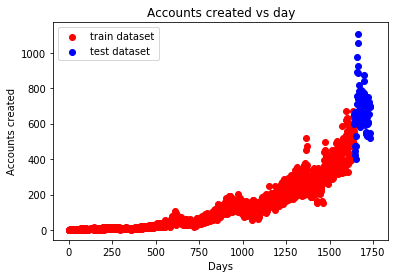

In [15]:
# matplotlib可视化
plt.scatter(dac_train_day.days, # 第一个轴
            dac_train.values, # 第二个轴
            color='r', # 颜色
            label='train dataset') # 标签

plt.scatter(dac_test_day.days, # 第一个轴
            dac_test.values, # 第二个轴
            color='b', # 颜色
            label='test dataset') # 标签

plt.title('Accounts created vs day') # 图的名称
plt.xlabel('Days') # x轴的标签
plt.ylabel('Accounts created') # y轴标签
plt.legend(loc='best') # 标签的放置位置

分析：
1. x轴：每个客户距离首个客户注册日期相差的天数
2. y轴：在每个相差的天数里注册的用户数量
3. 随着时间的增长，用户注册的数量在急剧上升

#### timestamp_first_active

**查看前5行数据**

In [16]:
print(train['timestamp_first_active'].head())

0    20090319043255
1    20090523174809
2    20090609231247
3    20091031060129
4    20091208061105
Name: timestamp_first_active, dtype: int64


**对数据进行统计，查看非重复值的数量**

In [17]:
print(train['timestamp_first_active'].value_counts().unique())

[1]


分析：结果[1]表明：timestamp_first_active没有重复数据

**将时间戳转换为日期形式并获取数据信息**

In [18]:
tfa_train_dt = train['timestamp_first_active'].astype(str).apply(lambda x: datetime.datetime(int(x[:4]), int(x[4:6]), int(x[6:8]), int(x[8:10]), int(x[10:12]), int(x[12:])))
print(tfa_train_dt.describe())

count                  213451
unique                 213451
top       2013-07-01 05:26:34
freq                        1
first     2009-03-19 04:32:55
last      2014-06-30 23:58:24
Name: timestamp_first_active, dtype: object


#### date_first_booking

**获取数据信息**

In [19]:
print(train['date_first_booking'].describe())
print(test['date_first_booking'].describe())

count          88908
unique          1976
top       2014-05-22
freq             248
Name: date_first_booking, dtype: object
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: date_first_booking, dtype: float64


分析：
1. train数据集中date_first_booking有大量的缺失值
2. test数据集中date_first_booking全都是缺失值
3. 可以删除date_first_booking特征

#### age

**对数据进行统计**

In [20]:
print(train['age'].value_counts().head())

30.0    6124
31.0    6016
29.0    5963
28.0    5939
32.0    5855
Name: age, dtype: int64


In [21]:
print(train['age'].value_counts().tail())

1933.0    1
1942.0    1
112.0     1
1938.0    1
1952.0    1
Name: age, dtype: int64


分析：用户年龄主要集中在30岁左右

**柱状图统计**

In [22]:
# 首先将年龄进行分成4组，missing values，too small age，reasonable age，too large age
age_train = [train[train['age'].isnull()]['age'].shape[0],
             train.query('age < 15')['age'].shape[0],
             train.query('age >= 15 & age <= 90')['age'].shape[0],
             train.query('age > 90')['age'].shape[0]]
print(age_train)

age_test = [test[test['age'].isnull()]['age'].shape[0],
            test.query('age < 15')['age'].shape[0],
            test.query('age >= 15 & age <= 90')['age'].shape[0],
            test.query('age > 90').age.shape[0]]
print(age_test)

[87990, 57, 122861, 2543]
[28876, 2, 32833, 385]


Text(0, 0.5, 'counts')

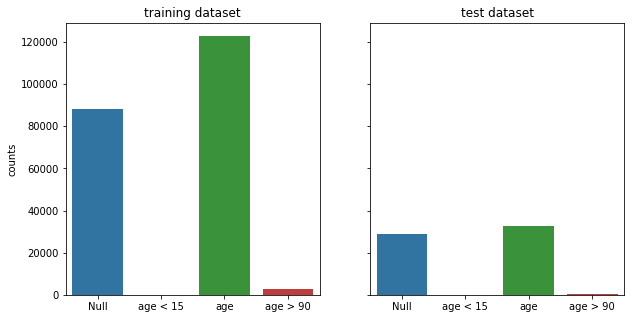

In [23]:
columns = ['Null', 'age < 15', 'age', 'age > 90']

# 可视化
fig, axes = plt.subplots(1, 2, # 1×2个子图
                         sharex=True, # 共享x轴
                         sharey=True, # 共享y轴
                         figsize=(10, 5)) # 子图的大小

sns.barplot(columns, # 第一个轴
            age_train, # 第二个轴
            ax=axes[0]) # 在第一个子图上画图
sns.barplot(columns, 
            age_test, 
            ax=axes[1])

axes[0].set_title('training dataset') # 图片的标题
axes[1].set_title('test dataset')
axes[0].set_ylabel('counts') # y轴名称

分析：异常年龄较少，且有一定数量的缺失值

#### 其他特征
- train数据集中，其他特征由于labels较少，可以在特征工程中直接进行one-hot-encoding

In [24]:
def feature_barplot(feature, df_train=train, df_test=test, figsize=(10, 5), rot=90, saveimg=False):
    feat_train = df_train[feature].value_counts()  # 统计各个值出现的次数
    feat_test = df_test[feature].value_counts()

    fig_feature, (axis1, axis2) = plt.subplots(1, 2, # 1×2个子图
                                               sharex=True, sharey=True, # 共享x、y轴
                                               figsize=figsize) # 图片的大小
    
    # 柱状图
    sns.barplot(feat_train.index.values, # 第一个轴
                feat_train.values, # 第二个轴
                ax=axis1) # 在第一个子图上画图
    sns.barplot(feat_test.index.values, 
                feat_test.values, 
                ax=axis2)
    
    # 设置x轴刻度
    axis1.set_xticklabels(axis1.xaxis.get_majorticklabels(), # 设置主要刻度标签
                          rotation=rot) # 刻度的旋转角度
    axis2.set_xticklabels(axis1.xaxis.get_majorticklabels(), # 设置主要刻度标签
                          rotation=rot) # 刻度的旋转角度
    
    # 设置子图的标题
    axis1.set_title(feature + ' of training dataset')
    axis2.set_title(feature + ' of test dataset')
    
    # 设置y轴标签
    axis1.set_ylabel('Counts')
    
    # 布局形式
    plt.tight_layout()
    if saveimg == True:
        figname = feature + '.png'
        fig_feature.savefig(figname, dpi=75)

##### gender

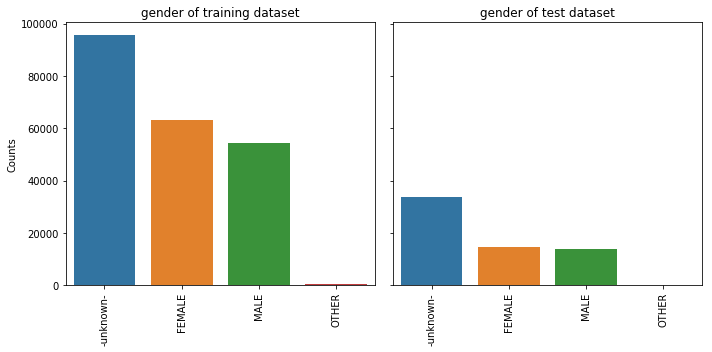

In [25]:
feature_barplot('gender', saveimg=True)

##### signup_method

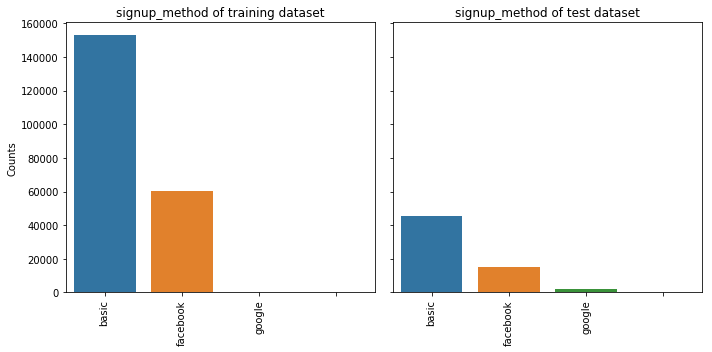

In [26]:
feature_barplot('signup_method')

##### signup_flow

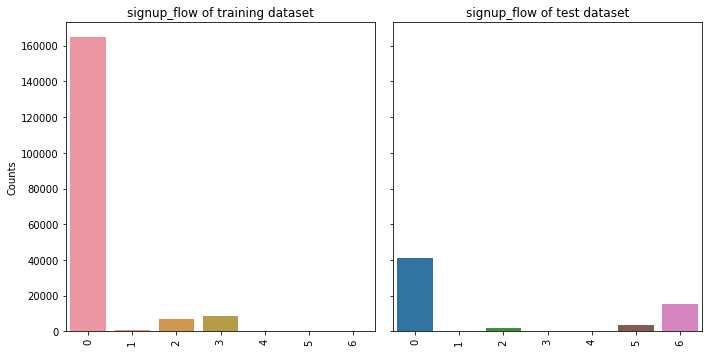

In [27]:
feature_barplot('signup_flow')

##### language

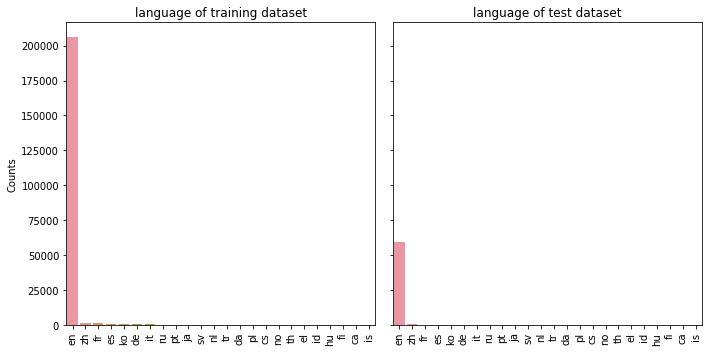

In [28]:
feature_barplot('language')

##### affiliate_channel

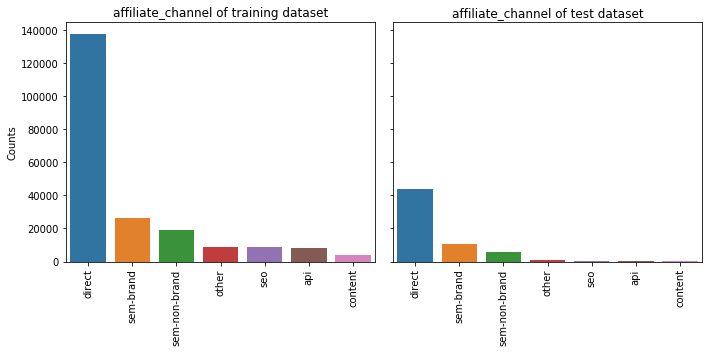

In [29]:
feature_barplot('affiliate_channel')

##### first_affiliate_tracked

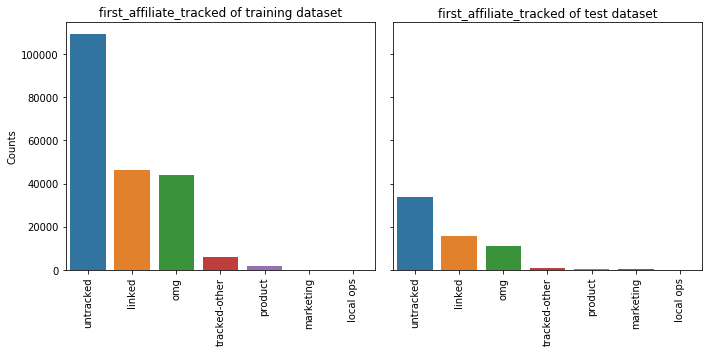

In [30]:
feature_barplot('first_affiliate_tracked')

##### signup_app

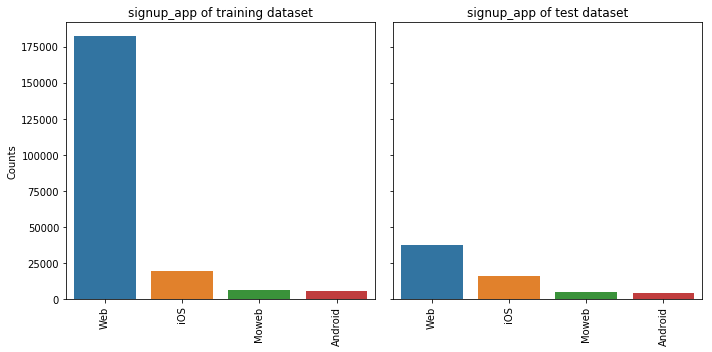

In [31]:
feature_barplot('signup_app')

##### first_device_type

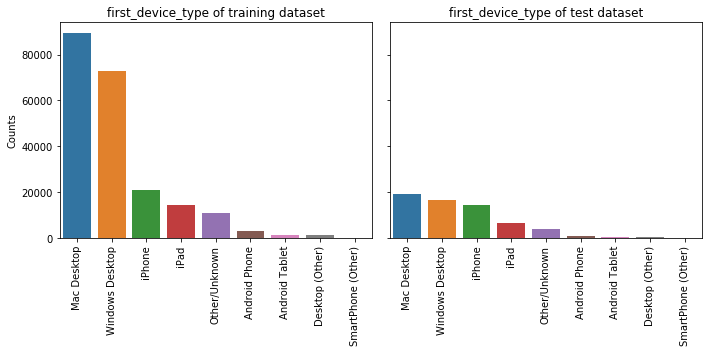

In [32]:
feature_barplot('first_device_type')

##### first_browser

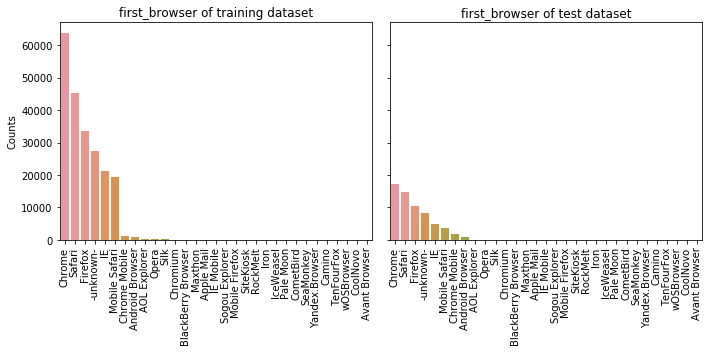

In [33]:
feature_barplot('first_browser')

### Session文件

**获取数据并查看前10行数据**

In [34]:
df_sessions = pd.read_csv('airbnb-recruiting-new-user-bookings/sessions.csv')
df_sessions.head(10)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


分析：session文件包含以下字段：
1. user_id：用户id
2. action：包括lookup、search_results、personalize等
3. action_type：行为类型，包括click、data、view等
4. action_detail：行为具体，包括view_search_results、wishlist_content_update、view_search_results等
5. device_type：设备类型，包括Windows Desktop等
6. secs_elapsed：停留时长

**将user_id改为id，方便之后的数据合并**

In [35]:
df_sessions.rename(columns={'user_id': 'id'}, # 用'id'来替换'user_id'
                   inplace=True)# 原地修改
df_sessions.columns

Index(['id', 'action', 'action_type', 'action_detail', 'device_type',
       'secs_elapsed'],
      dtype='object')

In [36]:
# 也可以先添加一列相同的数据，然后再删除
# df_sessions['id'] = df_session['user_id']
# df_sessions = df_sessions.drop(['user_id'], 
#                                axis=1) # 按列删除
# df_sessions.head()

**查看数据的shape**

In [37]:
df_sessions.shape

(10567737, 6)

分析：session文件中有10567737行数据，6个特征

**查看缺失值**

In [38]:
df_sessions.isnull().sum()

id                 34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

分析：action、action_type、action_detail、secs_elapsed这些特征的缺失值较多

**填充缺失值**

In [39]:
df_sessions['action'] = df_sessions['action'].fillna('NAN')
df_sessions['action_type'] = df_sessions['action_type'].fillna('NAN')
df_sessions['action_detail'] = df_sessions['action_detail'].fillna('NAN')
df_sessions.isnull().sum()

id                34496
action                0
action_type           0
action_detail         0
device_type           0
secs_elapsed     136031
dtype: int64

分析：
1. 填充后，缺失值的数量都已经为0了
2. secs_elapsed后续在做填充处理

### 对session文件做特征提取

#### action

In [40]:
df_sessions['action'].head()

0            lookup
1    search_results
2            lookup
3    search_results
4            lookup
Name: action, dtype: object

In [41]:
df_sessions['action'].value_counts()

show                           2768278
index                           843699
search_results                  725226
personalize                     706824
search                          536057
ajax_refresh_subtotal           487744
update                          365130
similar_listings                364624
social_connections              339000
reviews                         320591
active                          188036
similar_listings_v2             168788
lookup                          162041
create                          155887
dashboard                       152952
header_userpic                  141830
collections                     124417
edit                            109083
campaigns                       105028
track_page_view                  81117
NAN                              79626
unavailabilities                 78317
qt2                              64651
notifications                    59392
confirm_email                    58726
requested                

In [42]:
# argsort() 返回的是数组值从小到大的索引值
df_sessions['action'].value_counts().argsort()[:10]

show                     359
index                    345
search_results           346
personalize              347
search                   348
ajax_refresh_subtotal    349
update                   350
similar_listings         358
social_connections       352
reviews                  357
Name: action, dtype: int64

In [43]:
len(df_sessions['action'].value_counts().argsort())

360

In [44]:
df_sessions['action'].value_counts().min()

1

分析：对action进行统计，可以发现用户action有多种，且最少的发生次数只有1，接下来我们可以对用户发生次数较少的行为列为OTHER一类

**将特征action次数低于阈值100的列为OTHER**

In [45]:
# Action values with low frequency are changed to 'OTHER'
act_freq = 100 # Threshold of frequency
# np.unique(df_sessions.action, return_counts=True) 取以数组形式返回非重复的action值和它的数量
# zip(*(a,b))：a，b种元素一一对应，返回zip object
act = dict(zip(*np.unique(df_sessions['action'], return_counts=True)))
df_sessions['action'] = df_sessions['action'].apply(lambda x: 'OTHER' if act[x] < act_freq else x)

#### 对特征action，action_detail，action_type，device_type，secs_elapsed进行细化
- **id**：首先，将用户的特征根据用户id进行分组
- **特征action**：统计每个用户总的action出现的次数，各个action类型的数量，平均值以及标准差
- **特征action_detai**：统计每个用户总的action_detail出现的次数，各个action_detail类型的数量，平均值以及标准差
- **特征device_type**：统计每个用户总的device_type出现的次数，各个action_detail类型的数量，平均值以及标准差
- **特征secs_elapsed**：对缺失值用0填充，统计每个用户secs_elapsed时间的总和，平均值，标准差以及中位数（进行log处理），（总和/平均数），secs_elapsed（log处理后）各个时间出现的次数

In [46]:
# 对action特征进行细化，argsort()函数：返回数组值从小到大的索引值
f_act = df_sessions['action'].value_counts().argsort()
f_act_detail = df_sessions['action_detail'].value_counts().argsort()
f_act_type = df_sessions['action_type'].value_counts().argsort()
f_dev_type = df_sessions['device_type'].value_counts().argsort()

# 根据id进行分组
dgr_sess = df_sessions.groupby(['id']) # 每个客户都有一个唯一的id，记录每个id的行为数据
# Loop on dgr_sess to create all the features
samples = []
ln = len(dgr_sess) # 计算分组后df_session的长度

# 对dgr_sess中的每个id的数据进行遍历
# g[0]为id的唯一值
# g[1]为每个id的行为数据，见《利用Python进行数据分析》P278
for g in dgr_sess:
    gr = g[1]   # DataFrame that contains all the data for a groupby value 'zzywmcn0jv'
    
    l = [] # 建一个空列表，临时存放特征
    
    # the id for example 'zzywmcn0jv'
    l.append(g[0]) # 将id值放入空列表中
    
    # number of total actions
    l.append(len(gr)) # 将id对应的行为数据的长度放入列表
    
    # secs_elapsed特征中的缺失值用0填充再获取具体的停留时长值
    sev = gr.secs_elapsed.fillna(0).values # These values are used later.
    
    # action特征：用户行为 
    # 每个用户行为出现的次数，各个行为类型的数量，平均值以及标准差
    c_act = [0] * len(f_act) # 结果为[0, 0, 0, ..., 0]
    for i, v in enumerate(gr.action.values): # i是从0-1对应的位置，v是用户行为特征的值
        c_act[f_act[v]] += 1 # 结果为该用户的每种行为次数累加
    _, c_act_uqc = np.unique(gr.action.values, return_counts=True) # c_act_uqc为对每种行为去重，返回每种行为的次数
    # 计算用户行为特征各个类型数量的长度，平均值以及标准差
    c_act += [len(c_act_uqc), np.mean(c_act_uqc), np.std(c_act_uqc)]
    l = l + c_act
    
    # action_detail特征：用户具体行为
    # how many times each value occurs, numb of unique values, mean and std
    c_act_detail = [0] * len(f_act_detail)
    for i, v in enumerate(gr.action_detail.values):
        c_act_detail[f_act_detail[v]] += 1
    _, c_act_det_uqc = np.unique(gr.action_detail.values, return_counts=True)
    c_act_detail += [len(c_act_det_uqc), np.mean(c_act_det_uqc), np.std(c_act_det_uqc)]
    l = l + c_act_detail
    
    # action_type特征：用户行为类型，click、view等
    # how many times each value occurs, numb of unique values, mean and std
    # + log of the sum of secs_elapsed for each value)
    l_act_type = [0] * len(f_act_type)
    c_act_type = [0] * len(f_act_type)
    for i, v in enumerate(gr.action_type.values):
        l_act_type[f_act_type[v]] += sev[i] # sev = gr.secs_elapsed.fillna(0).values ，求每个行为类型总的停留时长
        c_act_type[f_act_type[v]] += 1  
    l_act_type = np.log(1 + np.array(l_act_type)).tolist() # 每个行为类型总的停留时长，差异比较大，进行log处理
    _, c_act_type_uqc = np.unique(gr.action_type.values, return_counts=True)
    c_act_type += [len(c_act_type_uqc), np.mean(c_act_type_uqc), np.std(c_act_type_uqc)]
    l = l + c_act_type + l_act_type    
    
    # device_type特征：设备类型
    # how many times each value occurs, numb of unique values, mean and std
    c_dev_type  = [0] * len(f_dev_type)
    for i, v in enumerate(gr.device_type .values):
        c_dev_type[f_dev_type[v]] += 1 
    c_dev_type.append(len(np.unique(gr.device_type.values))) 
    _, c_dev_type_uqc = np.unique(gr.device_type.values, return_counts=True)
    c_dev_type += [len(c_dev_type_uqc), np.mean(c_dev_type_uqc), np.std(c_dev_type_uqc)]        
    l = l + c_dev_type    
    
    # secs_elapsed特征：停留时长     
    l_secs = [0] * 5 # 结果为[0, 0, 0, 0, 0]
    l_log = [0] * 15 # 结果为[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    if len(sev) > 0:
        # Simple statistics about the secs_elapsed values.
        l_secs[0] = np.log(1 + np.sum(sev)) # 累计和
        l_secs[1] = np.log(1 + np.mean(sev)) # 均值
        l_secs[2] = np.log(1 + np.std(sev)) # 标准差
        l_secs[3] = np.log(1 + np.median(sev)) # 中位数
        l_secs[4] = l_secs[0] / float(l[1]) # np.log(1 + np.sum(sev)) / np.log(1 + np.mean(sev))
        
        # Values are grouped in 15 intervals. Compute the number of values in each interval.
        # sev = gr.secs_elapsed.fillna(0).values 
        log_sev = np.log(1 + sev).astype(int)
        # np.bincount(): Count number of occurrences of each value in array of non-negative ints.  
        l_log = np.bincount(log_sev, minlength=15).tolist()                    
    l = l + l_secs + l_log
    
    # The list l has the feature values of one sample.
    samples.append(l)

# preparing objects    
samples = np.array(samples) 
samp_ar = samples[:, 1:].astype(np.float16) # 取除id外的特征数据
samp_id = samples[:, 0]   # 取id，id位于第一列

# 为提取的特征创建一个DataFrame     
col_names = [] # name of the columns
for i in range(len(samples[0]) - 1): # 减1的原因是因为有个id
    col_names.append('c_' + str(i)) # 起名字的方式    
df_agg_sess = pd.DataFrame(samp_ar, columns=col_names)
df_agg_sess['id'] = samp_id
# df_agg_sess.index = df_agg_sess.id # 将id作为index

In [47]:
df_agg_sess.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_448,c_449,c_450,c_451,c_452,c_453,c_454,c_455,c_456,id
0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,6.0,2.0,3.0,3.0,1.0,0.0,1.0,0.0,00023iyk9l
1,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,12.0,2.0,8.0,4.0,3.0,0.0,0.0,0.0,0010k6l0om
2,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.0,30.0,9.0,8.0,1.0,0.0,0.0,0.0,0.0,001wyh0pz8
3,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,5.0,4.0,1.0,0.0,0.0,0.0,0028jgx1x1
4,789.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,111.0,102.0,104.0,57.0,28.0,9.0,4.0,1.0,1.0,002qnbzfs5


分析：经过特征提取后，session文件由6个特征变成458个特征

### 对train和test文件进行特征提取

**标记train文件的行数和存储需要预测的目标变量**
- labels存储需要预测的目标变量country_destination

In [48]:
train = pd.read_csv('airbnb-recruiting-new-user-bookings/train_users_2.csv')
test = pd.read_csv('airbnb-recruiting-new-user-bookings/test_users.csv')

# 计算处train的行数，便于之后对train和test数据进行分离操作
train_row = train.shape[0]

# The labels we need to predict
labels = train['country_destination'].values

**删除date_first_booking和train文件中的country_destination**
- 数据探索时，我们发现date_first_booking在train和test文件中缺失值太多，故删除
- 删除country_destination，用模型预测country_destination，再与已经存储的labels进行比较，从而判断模型优劣

In [49]:
train.drop(['country_destination', 'date_first_booking'], 
           axis=1, # 删除列 
           inplace=True) # 原地修改
test.drop(['date_first_booking'],
          axis=1, # 删除列
          inplace=True) # 原地修改

**合并train和test文件**
- 便于进行相同的特征提取

In [50]:
# 连接train和test文件
df = pd.concat([train, test], 
               axis=0, # 沿着行方向进行连接
               ignore_index=True) # 忽略之前的索引

#### timestamp_first_active

##### 转换为datetime类型

In [51]:
tfa = df.timestamp_first_active.astype(str).apply(lambda x: datetime.datetime(int(x[:4]),
                                                                              int(x[4:6]),
                                                                              int(x[6:8]),
                                                                              int(x[8:10]),
                                                                              int(x[10:12]),
                                                                              int(x[12:])))

##### 提取特征：年、月、日

In [52]:
df['tfa_year'] = np.array([x.year for x in tfa])
df['tfa_month'] = np.array([x.month for x in tfa])
df['tfa_day'] = np.array([x.day for x in tfa])

##### 提取特征：weekday
- 对结果进行one-hot-encoding

In [53]:
# isoweekday()函数返回一周的星期几，e.g.星期日：0，星期一：1
df['tfa_wd'] = np.array([x.isoweekday() for x in tfa])
df_tfa_wd = pd.get_dummies(df.tfa_wd, prefix='tfa_wd') # 独热编码
df = pd.concat((df, df_tfa_wd),
               axis=1) # 沿着列的方向连接，即添加特征（编码后的特征）
df.drop(['tfa_wd'], 
        axis=1, # 删除列 
        inplace=True) # 原地修改

##### 提取特征：季节
- 由于判断季节关注的是月份，故对年份进行统一

In [54]:
Y = 2000
seasons = [(0, (date(Y, 1, 1), date(Y, 3, 20))), # Winter
           (1, (date(Y, 3, 21), date(Y, 6, 20))), # Spring
           (2, (date(Y, 6, 21), date(Y, 9, 22))), # Summer
           (3, (date(Y, 9, 23), date(Y, 12, 20))), # Autumn
           (0, (date(Y, 12, 21), date(Y, 12, 31)))] # Winter

def get_season(dt):
    dt = dt.date() # 获取日期
    dt = dt.replace(year=Y) # 将年统一换成2000年的
    return next(season for season, (start, end) in seasons if start <= dt <= end)

df['tfa_season'] = np.array([get_season(x) for x in tfa])
df_tfa_season = pd.get_dummies(df.tfa_season, prefix='tfa_season') # 独热编码
df = pd.concat((df, df_tfa_season), 
               axis=1) # 沿着列方向连接
df.drop(['tfa_season'], 
        axis=1, # 删除列
        inplace=True) # 原地修改

#### date_account_created

##### 将date_account_created转换为datetime类型

In [55]:
dac = pd.to_datetime(df.date_account_created)

##### 提取特征：年、月、日

In [56]:
# create features of year, month, day for dac
df['dac_year'] = np.array([x.year for x in dac])
df['dac_month'] = np.array([x.month for x in dac])
df['dac_day'] = np.array([x.day for x in dac])

##### 提取特征：weekday

In [57]:
# create features of weekday for dac
df['dac_wd'] = np.array([x.isoweekday() for x in dac])
df_dac_wd = pd.get_dummies(df.dac_wd, prefix='dac_wd')
df = pd.concat((df, df_dac_wd), 
               axis=1) # 沿着列方向进行连接
df.drop(['dac_wd'], 
        axis=1, # 删除列
        inplace=True) # 原地修改

##### 提取特征：季节

In [58]:
# create season features for dac
df['dac_season'] = np.array([get_season(x) for x in dac])
df_dac_season = pd.get_dummies(df.dac_season, prefix='dac_season')
df = pd.concat((df, df_dac_season), 
               axis=1) # 沿着列方向进行连接
df.drop(['dac_season'], 
        axis=1, # 删除列
        inplace=True) # 原地修改

##### 提取特征：date_account_created和time_stamp_first_active之间的差值
- 即用户在Airbnb平台首次活跃到正式注册所花的时间，首次活跃时间可以早于平台注册时间或首次预定时间，因为一个客户可以在注册之前就有了搜索行为

In [59]:
# dt.days将timedelta对象转换为int类型
dt_span = dac.subtract(tfa).dt.days # 等价于(dac - tfa).dt.days

In [60]:
# 前10行
dt_span.value_counts().head(10)

-1     275369
 0          7
 6          4
 5          4
 1          4
 2          3
 3          3
 4          3
 28         3
 94         2
dtype: int64

In [61]:
dt_span = (dac - tfa).dt.days
dt_span.value_counts().head(10)

-1     275369
 0          7
 6          4
 5          4
 1          4
 2          3
 3          3
 4          3
 28         3
 94         2
dtype: int64

分析：数据主要集中在-1，可以猜测，用户当天注册的dt_span值便为-1
- 从差值提取特征：差值为一天，一个月，一年和其他，即用户活跃到注册所花的时间为一天，一个月，一年和其他

In [62]:
# create categorical features: span = -1; -1 < span < 30; 31 < span < 365; span > 365

def get_span(dt):
    # dt is an integer
    if dt == -1:
        return 'OneDay'
    elif -1 < dt <30:
        return 'OneMonth'
    elif 30 <= dt <= 365:
        return 'OneYear'
    else:
        return 'other'
    
df['dt_span'] = np.array([get_span(x) for x in dt_span])
df_dt_span = pd.get_dummies(df.dt_span, prefix='dt_span')
df = pd.concat((df, df_dt_span), 
               axis=1) # 沿着列方向进行连接
df.drop(['dt_span'], 
        axis=1, # 删除列
        inplace=True) # 原地修改

##### 删除原有特征
- 对timestamp_first_active，date_account_created进行特征提取后，从特征列表中删除原有的特征

In [63]:
df.drop(['date_account_created', 'timestamp_first_active'], 
        axis=1, # 删除列
        inplace=True) # 原地修改

#### age

In [64]:
# 获取年龄
av = df.age.values

- 在数据探索阶段，我们发现大部分数据都集中在(15, 90)区间内，但有部分年龄分布在(1900, 2000)区间内，我们猜测用户是把出生日期误填为年龄，故进行预处理

In [65]:
# This are birthdays instead of age (estimating age by doing 2014 - value)
# 数据来自2014年，故用2014- value
av = np.where(np.logical_and(av < 2000, av > 1900), 2014 - av, av)
df['age'] = av

C:\Users\z\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\z\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


##### 将年龄进行分段

In [66]:
# Age has many abnormal values that we need to deal with
age = df.age
age.fillna(-1, inplace=True) # 用-1来填充为空值
div = 15

def get_age(age):
    # 年龄是一个浮点型数据，将连续型转换为离散型
    if age < 0:
        return 'NA' # 表示空值
    elif age < div:
        return div # 如果年龄小于15岁，那么返回15岁
    elif age <= div * 2:
        return div * 2 # 如果年龄大于15小于等于30岁，则返回30岁
    elif age <= div * 3:
        return div * 3
    elif age <= div * 4:
        return div * 4
    elif age <= div * 5:
        return div * 5
    elif age <= 110:
        return div * 6
    else:
        return 'Unphysical' # 非正常年龄

- 将分段后的年龄作为新的特征放入特征列表中

In [67]:
df['age'] = np.array([get_age(x) for x in age])
df_age = pd.get_dummies(df.age, prefix='age')
df = pd.concat((df, df_age), 
               axis=1)
df.drop(['age'], 
        axis=1, 
        inplace=True)

#### 其他特征
- 在数据探索时，我们发现剩余的特征labels都比较少，故不进一步进行特征提取，只进行one-hot-encoding处理

In [68]:
feat_toOHE = ['gender',
              'signup_method',
              'signup_flow',
              'language',
              'affiliate_channel',
              'affiliate_provider',
              'first_affiliate_tracked',
              'signup_app',
              'first_device_type',
              'first_browser']

# 对其他特征进行one-hot-encoding处理
for f in feat_toOHE:
    df_ohe = pd.get_dummies(df[f], prefix=f, dummy_na=True)
    df.drop([f], axis=1, inplace=True)
    df = pd.concat((df, df_ohe), 
                   axis=1) # 沿着列方向进行连接

#### 整合提取到的所有特征
- 我们将对session以及train，test文件中提取的特征进行合并

In [69]:
df.head()

,id,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,...,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser,first_browser_nan
0,gxn3p5htnn,2009,3,19,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,820tgsjxq7,2009,5,23,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,4ft3gnwmtx,2009,6,9,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,2009,10,31,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,2009,12,8,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
df_agg_sess.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_448,c_449,c_450,c_451,c_452,c_453,c_454,c_455,c_456,id
0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,6.0,2.0,3.0,3.0,1.0,0.0,1.0,0.0,00023iyk9l
1,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,12.0,2.0,8.0,4.0,3.0,0.0,0.0,0.0,0010k6l0om
2,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.0,30.0,9.0,8.0,1.0,0.0,0.0,0.0,0.0,001wyh0pz8
3,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,5.0,4.0,1.0,0.0,0.0,0.0,0028jgx1x1
4,789.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,111.0,102.0,104.0,57.0,28.0,9.0,4.0,1.0,1.0,002qnbzfs5


In [71]:
# 将从session文件中提取到的特征整合到一起
df_all = pd.merge(df, df_agg_sess, 
                  how='left') # 左连接
df_all.head()

,id,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,...,c_447,c_448,c_449,c_450,c_451,c_452,c_453,c_454,c_455,c_456
0,gxn3p5htnn,2009,3,19,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,820tgsjxq7,2009,5,23,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2009,6,9,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2009,10,31,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,2009,12,8,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
df_all.drop(['id'], axis=1, inplace=True) # 删除'id'列
df_all = df_all.fillna(-2) # 对没有session的数据进行缺失值处理
df_all.head()

,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7,...,c_447,c_448,c_449,c_450,c_451,c_452,c_453,c_454,c_455,c_456
0,2009,3,19,0,0,0,1,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1,2009,5,23,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2,2009,6,9,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
3,2009,10,31,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
4,2009,12,8,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


In [73]:
# 添加一列，用于标识每一行总共有多少个空值
df_all['all_null'] = np.array([sum(r < 0) for r in df_all.values])

## 模型构建

### 数据准备

#### 将train和test数据进行分离操作
- train_row是之前记录的train数据的行数

In [74]:
Xtrain = df_all.iloc[:train_row, :]
Xtest = df_all.iloc[train_row:, :]

#### 将提取的特征生成csv文件

In [75]:
Xtrain.to_csv('Airbnb_xtrain_v2.csv')
Xtest.to_csv('Airbnb_xtest_v2.csv')
# labels.tofile(): Write array to a file as text or binary (default)
labels.tofile('Airbnb_ytrain_v2.csv', sep='\n', format='%s') # 存放目标变量

- 读取特征文件

In [76]:
xtrain = pd.read_csv('Airbnb_xtrain_v2.csv', index_col=0)
ytrain = pd.read_csv('Airbnb_ytrain_v2.csv', header=None)

In [77]:
xtrain.head()

,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7,...,c_448,c_449,c_450,c_451,c_452,c_453,c_454,c_455,c_456,all_null
0,2009,3,19,0,0,0,1,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
1,2009,5,23,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
2,2009,6,9,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
3,2009,10,31,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
4,2009,12,8,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457


In [78]:
ytrain.head()

,0
0,NDF
1,NDF
2,US
3,other
4,US


分析：可以发现经过特征提取后，特征文件xtrain扩展为661个特征，ytrain中包含训练集中的目标变量

#### 将目标变量进行labels encoding

In [79]:
le = LabelEncoder()
ytrain_le = le.fit_transform(ytrain.values.reshape(-1, ))

In [80]:
ytrain_le.shape

(213451,)

In [81]:
ytrain_le[:5]

array([ 7,  7, 10, 11, 10])

In [82]:
np.unique(ytrain)

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US',
       'other'], dtype=object)

In [83]:
np.unique(ytrain_le)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

- labels encoding前：

['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']

- labels encoding后：

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

#### 提取10%的数据进行模型训练
- 减少训练模型所花费的时间

In [84]:
# Let us take 10% of the data for faster training.
n = int(xtrain.shape[0] * 0.1)
xtrain_new = xtrain.iloc[:n, :] # 训练数据
ytrain_new = ytrain_le[:n]

#### StandardScaling the dataset
- Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance)

In [85]:
X_scaler = StandardScaler()
xtrain_new = X_scaler.fit_transform(xtrain_new)

C:\Users\z\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## 评分模型：NDCG

- NDCG是一种衡量排序质量的评价指标，该指标考虑了所有元素的相关性
- 由于我们预测的目标变量并不是二分类变量，故我们用NDGG模型来进行模型评分，判断模型优劣
- 一般二分类变量: 我们习惯于使用 f1 score, precision, recall, auc score来进行模型评分

In [86]:
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    
    """
    y_true : array, shape = [n_samples] # 数据
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes] # 预测的分数
        Predicted scores.
    k : int
    """
    order = np.argsort(y_score)[::-1] # 分数从高到低排序
    y_true = np.take(y_true, order[:k]) # 取出前k[0,k）个分数
      
    gain = 2 ** y_true - 1   

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)
  

def ndcg_score(ground_truth, predictions, k=5):   
    """
    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes] 
        Predicted probabilities. 预测的概率
    k : int
        Rank.
    """
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)    
    scores = []
    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

## 构建模型

### Logistic Regression

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
lr = LogisticRegression(C=1.0, penalty='l2', multi_class='ovr')
RANDOM_STATE = 2017  # 随机种子

# k-fold cross validation（k-折叠交叉验证）
kf = KFold(n_splits=5, random_state=RANDOM_STATE) # 分成5个组
train_score = []
cv_score = []

# select a k  (value how many y):
k_ndcg = 3 
# kf.split: Generate indices to split data into training and test set.
for train_index, test_index in kf.split(xtrain_new, ytrain_new):
    # 训练集数据分割为训练集和测试集，y是目标变量
    X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
    y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]
        
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict_proba(X_test)
    train_ndcg_score = ndcg_score(y_train, lr.predict_proba(X_train), k=k_ndcg)
    cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)
    
    train_score.append(train_ndcg_score)
    cv_score.append(cv_ndcg_score)
    
print ("\nThe training score is: {}".format(np.mean(train_score)))
print ("\nThe cv score is: {}".format(np.mean(cv_score)))

C:\Users\z\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur


The training score is: 0.7595157690333219

The cv score is: 0.7417455860527811


#### 观察逻辑回归模型学习曲线的变化
1. 改变逻辑回归参数iteration

In [88]:
# set the iterations
iteration = [1, 5, 10, 15, 20, 50, 100]

kf = KFold(n_splits=3, random_state=RANDOM_STATE)

train_score = []
cv_score = []

# select a k:
k_ndcg = 5

for i, item in enumerate(iteration): 

    lr = LogisticRegression(C=1.0, max_iter=item, tol=1e-5, solver='newton-cg', multi_class='ovr') 
    train_score_iter = []
    cv_score_iter = []

    for train_index, test_index in kf.split(xtrain_new, ytrain_new):
        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]
       
        lr.fit(X_train, y_train)

        y_pred = lr.predict_proba(X_test)
        train_ndcg_score = ndcg_score(y_train, lr.predict_proba(X_train), k=k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        
        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
        
    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))

C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

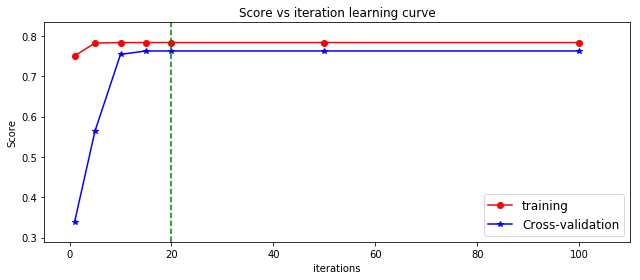

In [89]:
ymin = np.min(cv_score) - 0.05
ymax = np.max(train_score) + 0.05

plt.figure(figsize=(9,4))
plt.plot(iteration, train_score,
         'ro-', 
         label = 'training')
plt.plot(iteration, cv_score,
         'b*-',
         label = 'Cross-validation')
plt.xlabel("iterations")
plt.ylabel("Score")
plt.xlim(-5, np.max(iteration) + 10)
plt.ylim(ymin, ymax)
plt.plot(np.linspace(20, 20, 50), np.linspace(ymin, ymax, 50),
         'g--')
plt.legend(loc='lower right', fontsize = 12)
plt.title("Score vs iteration learning curve")

plt.tight_layout()

分析：随着iteration的增大，逻辑回归模型的评分在不断升高，当iteration超过20的时候，模型的评分基本不变

2. 改变数据量大小

In [90]:
# Chaning the sampling size
# set the iter to the best iteration: iter = 20

perc = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

kf = KFold(n_splits=3, random_state=RANDOM_STATE)

train_score = []
cv_score = []

# select a k:
k_ndcg = 5

for i, item in enumerate(perc):
    
    lr = LogisticRegression(C=1.0, max_iter=20, tol=1e-6, solver='newton-cg', multi_class='ovr')
    train_score_iter = []
    cv_score_iter = []
    
    n = int(xtrain_new.shape[0] * item)
    xtrain_perc = xtrain_new[:n, :]
    ytrain_perc = ytrain_new[:n]


    for train_index, test_index in kf.split(xtrain_perc, ytrain_perc):
        
        X_train, X_test = xtrain_perc[train_index, :], xtrain_perc[test_index, :]
        y_train, y_test = ytrain_perc[train_index], ytrain_perc[test_index]

        print(X_train.shape, X_test.shape)
        
        lr.fit(X_train, y_train)

        y_pred = lr.predict_proba(X_test)
        train_ndcg_score = ndcg_score(y_train, lr.predict_proba(X_train), k=k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
        
    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))

(142, 661) (71, 661)
(142, 661) (71, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(142, 661) (71, 661)
(284, 661) (142, 661)
(284, 661) (142, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(284, 661) (142, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(711, 661) (356, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(711, 661) (356, 661)
(712, 661) (355, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(1422, 661) (712, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(1423, 661) (711, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(1423, 661) (711, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(2846, 661) (1423, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(2846, 661) (1423, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

(2846, 661) (1423, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

(7114, 661) (3558, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

(7115, 661) (3557, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

(7115, 661) (3557, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

(14230, 661) (7115, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

(14230, 661) (7115, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

(14230, 661) (7115, 661)


C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

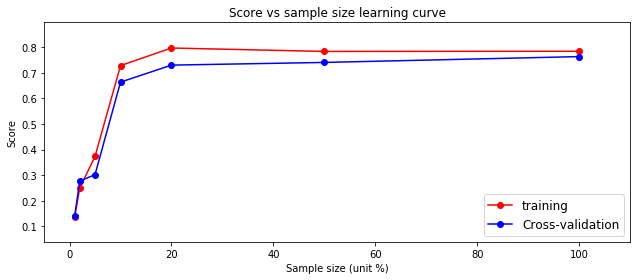

In [91]:
ymin = np.min(cv_score) - 0.1
ymax = np.max(train_score) + 0.1

plt.figure(figsize=(9,4))
plt.plot(np.array(perc) * 100, train_score,
         'ro-', 
         label = 'training')
plt.plot(np.array(perc) * 100, cv_score,
         'bo-',
         label = 'Cross-validation')
plt.xlabel("Sample size (unit %)")
plt.ylabel("Score")
plt.xlim(-5, np.max(perc) * 100 + 10)
plt.ylim(ymin, ymax)

plt.legend(loc='lower right', fontsize=12)
plt.title("Score vs sample size learning curve")

plt.tight_layout()

分析：随着数据量的增加，逻辑回归模型对测试集的预测评分（蓝色线）在不断上升，因为我们在训练模型时只用了10%的数据，如果使用全部的数据，效果可能会更好b

### 树模型
- 其中的模型包括DecisionTree，RandomForest，AdaBoost，Bagging，ExtraTree，GraBoost

In [92]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import *
from sklearn.svm import SVC, LinearSVC, NuSVC
LEARNING_RATE = 0.1
N_ESTIMATORS = 50
RANDOM_STATE = 2017
MAX_DEPTH = 9

#建了一个tree字典
clf_tree ={
    'DTree': DecisionTreeClassifier(max_depth=MAX_DEPTH,
                                    random_state=RANDOM_STATE),
    
    'RF': RandomForestClassifier(n_estimators=N_ESTIMATORS,
                                 max_depth=MAX_DEPTH,
                                 random_state=RANDOM_STATE),
    
    'AdaBoost': AdaBoostClassifier(n_estimators=N_ESTIMATORS,
                                   learning_rate=LEARNING_RATE,
                                   random_state=RANDOM_STATE),
    
    'Bagging': BaggingClassifier(n_estimators=N_ESTIMATORS,
                                 random_state=RANDOM_STATE),
    
    'ExtraTree': ExtraTreesClassifier(max_depth=MAX_DEPTH,
                                      n_estimators=N_ESTIMATORS,
                                      random_state=RANDOM_STATE),
    
    'GraBoost': GradientBoostingClassifier(learning_rate=LEARNING_RATE,
                                           max_depth=MAX_DEPTH,
                                           n_estimators=N_ESTIMATORS,
                                           random_state=RANDOM_STATE)
}
train_score = []
cv_score = []

kf = KFold(n_splits=3, random_state=RANDOM_STATE)

k_ndcg = 5

for key in clf_tree.keys():
    
    clf = clf_tree.get(key)
    
    train_score_iter = []
    cv_score_iter = []

    for train_index, test_index in kf.split(xtrain_new, ytrain_new):

        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]
        
        clf.fit(X_train, y_train)

        y_pred = clf.predict_proba(X_test)
        train_ndcg_score = ndcg_score(y_train, clf.predict_proba(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
        
    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))

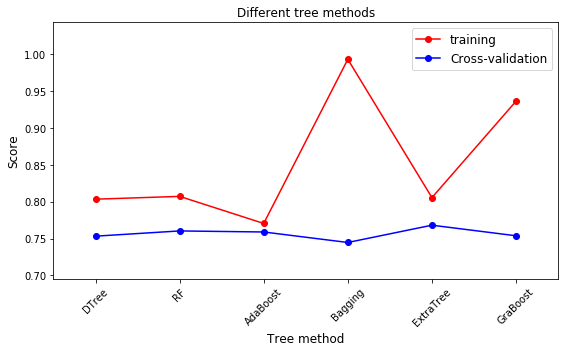

In [93]:
train_score_tree = train_score
cv_score_tree = cv_score

ymin = np.min(cv_score)-0.05
ymax = np.max(train_score)+0.05

x_ticks = clf_tree.keys()

plt.figure(figsize=(8,5))
plt.plot(range(len(x_ticks)), train_score_tree, 'ro-', label = 'training')
plt.plot(range(len(x_ticks)),cv_score_tree, 'bo-', label = 'Cross-validation')

plt.xticks(range(len(x_ticks)),x_ticks,rotation = 45, fontsize = 10)
plt.xlabel("Tree method", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.xlim(-0.5, 5.5)
plt.ylim(ymin, ymax)

plt.legend(loc = 'best', fontsize = 12)
plt.title("Different tree methods")

plt.tight_layout()

### SVM模型
- 根据核函数的不同，又分为：SVM-rbf，SVM-poly，SVM-linear等

In [94]:
TOL = 1e-4
MAX_ITER = 1000

clf_svm = {
    
    'SVM-rbf': SVC(kernel='rbf',
                   max_iter=MAX_ITER,
                   tol=TOL, random_state=RANDOM_STATE,
                   decision_function_shape='ovr'),     
    
    'SVM-poly': SVC(kernel='poly',
                   max_iter=MAX_ITER,
                   tol=TOL, random_state=RANDOM_STATE,
                   decision_function_shape='ovr'),     
    
    'SVM-linear': SVC(kernel='linear',
                      max_iter=MAX_ITER,
                      tol=TOL, 
                      random_state=RANDOM_STATE,
                      decision_function_shape='ovr'),  
    
    'LinearSVC': LinearSVC(max_iter=MAX_ITER,
                            tol=TOL,
                            random_state=RANDOM_STATE,
                            multi_class = 'ovr')  
                            
}     

train_score_svm = []
cv_score_svm = []

kf = KFold(n_splits=3, random_state=RANDOM_STATE)

k_ndcg = 5

for key in clf_svm.keys():
    
    clf = clf_svm.get(key)

    train_score_iter = []
    cv_score_iter = []

    for train_index, test_index in kf.split(xtrain_new, ytrain_new):

        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]
        
        clf.fit(X_train, y_train)

        y_pred = clf.decision_function(X_test)
        train_ndcg_score = ndcg_score(y_train, clf.decision_function(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
        
    train_score_svm.append(np.mean(train_score_iter))
    cv_score_svm.append(np.mean(cv_score_iter))

C:\Users\z\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\z\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your dat

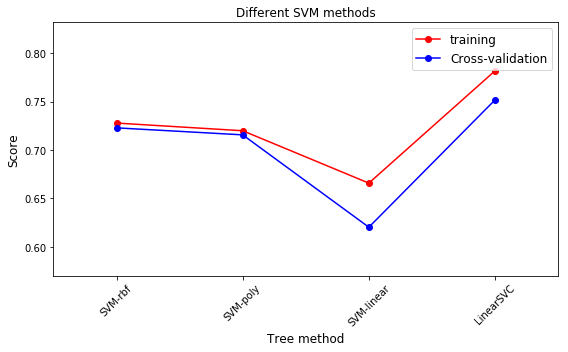

In [95]:
ymin = np.min(cv_score_svm)-0.05
ymax = np.max(train_score_svm)+0.05

x_ticks = clf_svm.keys()

plt.figure(figsize=(8,5))
plt.plot(range(len(x_ticks)), train_score_svm, 'ro-', label = 'training')
plt.plot(range(len(x_ticks)),cv_score_svm, 'bo-', label = 'Cross-validation')

plt.xticks(range(len(x_ticks)),x_ticks,rotation = 45, fontsize = 10)
plt.xlabel("Tree method", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.xlim(-0.5, 3.5)
plt.ylim(ymin, ymax)

plt.legend(loc = 'best', fontsize = 12)
plt.title("Different SVM methods")

plt.tight_layout()

### xgboost
- kaggle比赛中常用的一个模型

In [97]:
import xgboost as xgb

def customized_eval(preds, dtrain):
    labels = dtrain.get_label()
    top = []
    for i in range(preds.shape[0]):
        top.append(np.argsort(preds[i])[::-1][:5])
    mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int)
    score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1))
    return 'ndcg5', score
# xgboost parameters

NUM_XGB = 200

params = {}
params['colsample_bytree'] = 0.6
params['max_depth'] = 6
params['subsample'] = 0.8
params['eta'] = 0.3
params['seed'] = RANDOM_STATE
params['num_class'] = 12
params['objective'] = 'multi:softprob'   # output the probability instead of class. 
train_score_iter = []
cv_score_iter = []

kf = KFold(n_splits = 3, random_state=RANDOM_STATE)

k_ndcg = 5

for train_index, test_index in kf.split(xtrain_new, ytrain_new):

    X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
    y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]
    
    train_xgb = xgb.DMatrix(X_train, label= y_train)
    test_xgb = xgb.DMatrix(X_test, label = y_test)
    
    watchlist = [ (train_xgb,'train'), (test_xgb, 'test') ]

    bst = xgb.train(params, 
                     train_xgb,
                     NUM_XGB,
                     watchlist,
                     feval = customized_eval,
                     verbose_eval = 3,
                     early_stopping_rounds = 5)
    
    
    #bst = xgb.train( params, dtrain, num_round, evallist )

    y_pred = np.array(bst.predict(test_xgb))
    y_pred_train = np.array(bst.predict(train_xgb))
    train_ndcg_score = ndcg_score(y_train, y_pred_train , k = k_ndcg)
    cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

    train_score_iter.append(train_ndcg_score)
    cv_score_iter.append(cv_ndcg_score)

train_score_xgb = np.mean(train_score_iter)
cv_score_xgb = np.mean(cv_score_iter)

print ("\nThe training score is: {}".format(train_score_xgb))
print ("The cv score is: {}\n".format(cv_score_xgb))

C:\Users\z\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


[0]	train-merror:0.42066	test-merror:0.50611	train-ndcg5:0.79767	test-ndcg5:0.74534
Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 5 rounds.
[3]	train-merror:0.40836	test-merror:0.49361	train-ndcg5:0.80777	test-ndcg5:0.75244
Stopping. Best iteration:
[0]	train-merror:0.42066	test-merror:0.50611	train-ndcg5:0.79767	test-ndcg5:0.74534

[0]	train-merror:0.45144	test-merror:0.45285	train-ndcg5:0.77963	test-ndcg5:0.78126
Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 5 rounds.
[3]	train-merror:0.43640	test-merror:0.44146	train-ndcg5:0.79151	test-ndcg5:0.78824
Stopping. Best iteration:
[0]	train-merror:0.45144	test-merror:0.45285	train-ndcg5:0.77963	test-ndcg5:0.78126

[0]	train-merror:0.43450	test-merror:0.46044	train-ndcg5:0.78943	test-ndcg5:0.76967
Multiple eval metrics have been passed: 'test-ndcg5' will be used for 

## 模型比较

In [99]:
model_cvscore = np.hstack((cv_score, cv_score_tree, cv_score_svm, cv_score_xgb))
model_name = np.array(['LinearReg','ExtraTree','DTree','RF','GraBoost','Bagging','AdaBoost','LinearSVC','SVM-linear','SVM-rbf','SVM-poly','Xgboost'])
fig = plt.figure(figsize=(8,4))

sns.barplot(model_cvscore, model_name, palette="Blues_d")

plt.xticks(rotation=0, size = 10)
plt.xlabel("CV score", fontsize = 12)
plt.ylabel("Model", fontsize = 12)
plt.title("Cross-validation score for different models")

plt.tight_layout()

ValueError: Grouper and axis must be same length

<Figure size 576x288 with 0 Axes>

## 总结
1. 对数据的理解和探索很重要
2. 可以通过特征工程，进一步提取特征
3. 模型评估的方法有很多种，选取适宜的模型评估方法
4. 目前只用了10%的数据进行模型训练，用全部的数据集进行训练，效果可能会更好
5. 需要深入学习模型算法，学会调参